In [4]:
import pandas as pd
from pathlib import Path
import numpy as np

In [5]:
code_dir=Path.cwd()
project_dir=code_dir.parent
input_dir=project_dir/"input"
output_dir=project_dir/"output/roiwise_prediction"
tmp_dir=project_dir/"tmp"

output_dir.mkdir(exist_ok=True)

In [8]:
prediction_df = pd.read_csv(input_dir/"prediction_df.csv")

schaefer_labels = pd.read_csv(input_dir/f"atlases/edited_Schaefer400Parcels7Networks_labels.txt", delim_whitespace=True).columns.to_list()
hcp1065_labels = pd.read_csv(input_dir/f"atlases/HCP1065_labels.txt", delim_whitespace=True, header=None, index_col=0).index.to_list()
tian_labels = pd.read_csv(input_dir/f"atlases/Tian_Subcortex_S1_3T_label.txt", delim_whitespace=True, header=None, index_col=0).index.to_list()

In [15]:
base_variables = ["Age","sex_int", "Education"]

lesion_data_modalities = ["sLNM", "fLNM", 
    "roiWMH", "WMHvolume"]

subj_list = prediction_df.index.tolist()

# Prediction

In [19]:
from sklearn.metrics import make_scorer

from julearn.scoring import register_scorer
import scipy

def pearson_scorer(y_pred, y_true):
    return scipy.stats.pearsonr(y_pred, y_true)[0]

register_scorer(scorer_name='pearsonr', scorer=make_scorer(pearson_scorer))

In [20]:
import julearn
import sklearn

print(julearn.__version__)
print(sklearn.__version__)

0.3.0
1.3.2


In [22]:
from julearn import run_cross_validation
from julearn.utils import configure_logging
from julearn.pipeline import PipelineCreator
from julearn.model_selection import RepeatedContinuousStratifiedKFold

configure_logging(level="ERROR")

# Cross-validation

In [23]:
scores_dict = {}
model_dict = {}
inspector_dict = {}
result_df = pd.DataFrame()
train_score_df = pd.DataFrame()

In [ ]:
analysis_name = "ridge_confounds"
scoring = ["pearsonr", "explained_variance"]
cv = RepeatedContinuousStratifiedKFold(n_bins=10, method="binning", n_splits=10, n_repeats=10, random_state=42)


search_params = {
    "kind": "grid",
}

for cognitive_domain in clinical_variables:
    
    X_all = []

    pipeline1 = PipelineCreator(problem_type="regression")
    pipeline1.add("zscore")
    pipeline1.add("ridge",
                alpha = np.logspace(-3, 3, 7),
                name="model",
    )


    prediction_df_metric = prediction_df.dropna(subset=[cognitive_domain] + base_variables)
    key = f"{analysis_name}_{cognitive_domain}"
    scores_dict[key], model_dict[key], inspector_dict[key] = run_cross_validation(
        X=base_variables, y=cognitive_domain, data=prediction_df_metric,
        model=[pipeline1], cv = cv, return_estimator='all',
        scoring=scoring, return_train_score=True,search_params=search_params,
        return_inspector= True, n_jobs=15)
    
    result_df.loc[analysis_name, cognitive_domain] = scores_dict[key]["test_pearsonr"].mean(axis=0)
    train_score_df.loc[analysis_name, cognitive_domain] = scores_dict[key]["train_pearsonr"].mean(axis=0)

    pipeline1 = PipelineCreator(problem_type="regression")
    pipeline1.add("zscore")
    pipeline1.add("ridge",
                alpha = np.logspace(-3, 3, 7),
                name="model",
    )

    for modality in lesion_data_modalities:
        
        modality_styled = modality.replace("_", "-")
        search_string = f"{modality}"
        X = [col for col in prediction_df.columns if search_string in col]
        X_all.append(X)

        prediction_df_metric = prediction_df.dropna(subset=[cognitive_domain] + base_variables + X)
        key = f"{analysis_name}_{modality}-plus-confounds_{cognitive_domain}"
        scores_dict[key], model_dict[key], inspector_dict[key] = run_cross_validation(
            X=base_variables + X, y=cognitive_domain, data=prediction_df_metric,
            model=[pipeline1], cv = cv, return_estimator='all',
            scoring=scoring, return_train_score=True,search_params=search_params,
            return_inspector= True, n_jobs=15)
        result_df.loc[f"{modality}-plus-confounds_multimodel", cognitive_domain] = scores_dict[key]["test_pearsonr"].mean(axis=0)
        train_score_df.loc[f"{modality}-plus-confounds_multimodel", cognitive_domain] = scores_dict[key]["train_pearsonr"].mean(axis=0)

    X_all = list(set([item for sublist in X_all for item in sublist]))

    X_all_nowmh = list(set([item for item in X_all if "WMH" not in item]))
    
    print(X_all_nowmh)


    prediction_df_metric = prediction_df.dropna(subset=[cognitive_domain] + base_variables + X_all_nowmh)
    key = f"{analysis_name}_all-no-wmh-plus-confounds_{cognitive_domain}"
    scores_dict[key], model_dict[key], inspector_dict[key] = run_cross_validation(
        X=base_variables + X_all_nowmh, y=cognitive_domain, data=prediction_df_metric, 
        model=[pipeline1], cv = cv, return_estimator='all',
        scoring=scoring, return_train_score=True,search_params=search_params,
        return_inspector= True, n_jobs=15)
    result_df.loc[f"all-no-wmh-plus-confounds_multimodel", cognitive_domain] = scores_dict[key]["test_pearsonr"].mean(axis=0)
    train_score_df.loc[f"all-no-wmh-plus-confounds_multimodel", cognitive_domain] = scores_dict[key]["train_pearsonr"].mean(axis=0)

In [21]:
# save result_df, scores_dict, model_dict and inspector_dict as pickle
import pickle

# Assuming result_df, scores_dict, model_dict, and inspector_dict are already defined

# Save result_df as a pickle file
with open(output_dir/'result_df.pkl', 'wb') as file:
    pickle.dump(result_df, file)

# Save scores_dict as a pickle file
with open(output_dir/'scores_dict.pkl', 'wb') as file:
    pickle.dump(scores_dict, file)

# Save model_dict as a pickle file
with open(output_dir/'model_dict.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

# Save inspector_dict as a pickle file
with open(output_dir/'inspector_dict.pkl', 'wb') as file:
    pickle.dump(inspector_dict, file)




In [78]:
import pickle

# Load result_df from its pickle file
with open(output_dir/'result_df.pkl', 'rb') as file:
    result_df = pickle.load(file)

# Load scores_dict from its pickle file
with open(output_dir/'scores_dict.pkl', 'rb') as file:
    scores_dict = pickle.load(file)

# Load model_dict from its pickle file
with open(output_dir/'model_dict.pkl', 'rb') as file:
    model_dict = pickle.load(file)

# Load inspector_dict from its pickle file
with open(output_dir/'inspector_dict.pkl', 'rb') as file:
    inspector_dict = pickle.load(file)


# Visualization

In [79]:
from julearn.stats import corrected_ttest
 
test_scores_plotting_df = pd.DataFrame()
train_scores_plotting_df = pd.DataFrame()

pval_comparison_confounds_df = pd.DataFrame()
pval_comparison_WMHvol_df = pd.DataFrame()
pval_comparison_roiWMHvol_df = pd.DataFrame()

counter = 0

for k, v in scores_dict.items():

    index = "_".join(k.split("_")[:-1]).replace("_verbal","")
    variable = k.split("_")[-1].replace("memory","verbal_memory")

    ttest_result_confounds = corrected_ttest(v, scores_dict[f"ridge_confounds_{variable}"], alternative="greater").loc[0,"p-val"]
    ttest_result_WMHvol = corrected_ttest(v, scores_dict[f"ridge_confounds_WMHvolume-plus-confounds_{variable}"], alternative="greater").loc[0,"p-val"]
    ttest_result_roiWMHvol = corrected_ttest(v, scores_dict[f"ridge_confounds_roiWMH-plus-confounds_{variable}"], alternative="greater").loc[0,"p-val"]

    pval_comparison_confounds_df.loc[index,variable] = ttest_result_confounds
    pval_comparison_WMHvol_df.loc[index,variable] = ttest_result_WMHvol
    pval_comparison_roiWMHvol_df.loc[index,variable] = ttest_result_roiWMHvol

    for iteration in v.index:
        
        test_scores_plotting_df.loc[counter,"index"] = index
        test_scores_plotting_df.loc[counter,"variable"] = variable 
        test_scores_plotting_df.loc[counter,"iteration"] = str(int(iteration)) 
        test_scores_plotting_df.loc[counter,"value"] = v.loc[iteration,"test_pearsonr"]

        train_scores_plotting_df.loc[counter,"index"] = index
        train_scores_plotting_df.loc[counter,"variable"] = variable
        train_scores_plotting_df.loc[counter,"iteration"] = str(int(iteration))
        train_scores_plotting_df.loc[counter,"value"] = v.loc[iteration,"train_pearsonr"]

        counter += 1

In [92]:
cognitive_domain_styling_dict = {
    "attention":"Attention / Executive function",
    "ips":"Information processing speed",
    "language": "Language",
    "verbal_memory":"Verbal memory"
}

feature_set_styling_dict = {
    'ridge_confounds':"Confounds (age, sex and education)",
    'ridge_confounds_WMHvolume-plus-confounds':"WMH volume + confounds",
    'ridge_confounds_roiWMH-plus-confounds':"Tract-level WMH volumes + confounds",
    'ridge_confounds_sLNM-plus-confounds':"sLNM + confounds",
    'ridge_confounds_fLNM-plus-confounds':"fLNM + confounds",
    'ridge_confounds_all-no-wmh-plus-confounds':"sLNM + fLNM + confounds"
}    

test_scores_plotting_df["index"] = test_scores_plotting_df["index"].replace(feature_set_styling_dict)
test_scores_plotting_df["variable"] = test_scores_plotting_df["variable"].replace(cognitive_domain_styling_dict)

train_scores_plotting_df["index"] = train_scores_plotting_df["index"].replace(feature_set_styling_dict)
train_scores_plotting_df["variable"] = train_scores_plotting_df["variable"].replace(cognitive_domain_styling_dict)

pval_comparison_confounds_df = pval_comparison_confounds_df.rename(
    index = feature_set_styling_dict,
    columns = cognitive_domain_styling_dict 
)

pval_comparison_roiWMHvol_df = pval_comparison_roiWMHvol_df.rename(
    index = feature_set_styling_dict,
    columns = cognitive_domain_styling_dict 
)

pval_comparison_WMHvol_df = pval_comparison_WMHvol_df.rename(
    index = feature_set_styling_dict,
    columns = cognitive_domain_styling_dict 
)

In [93]:
cognitive_domain_order = cognitive_domain_styling_dict.values()
feature_set_order = list(feature_set_styling_dict.values())

In [94]:
test_scores_plotting_df['index'] = pd.Categorical(
    test_scores_plotting_df['index'],
    categories=feature_set_order,
    ordered=True
)
test_scores_plotting_df = test_scores_plotting_df.sort_values(by=["index","variable"])

train_scores_plotting_df['index'] = pd.Categorical(
    train_scores_plotting_df['index'],
    categories=feature_set_order,
    ordered=True
)
train_scores_plotting_df = train_scores_plotting_df.sort_values(by=["index","variable"])

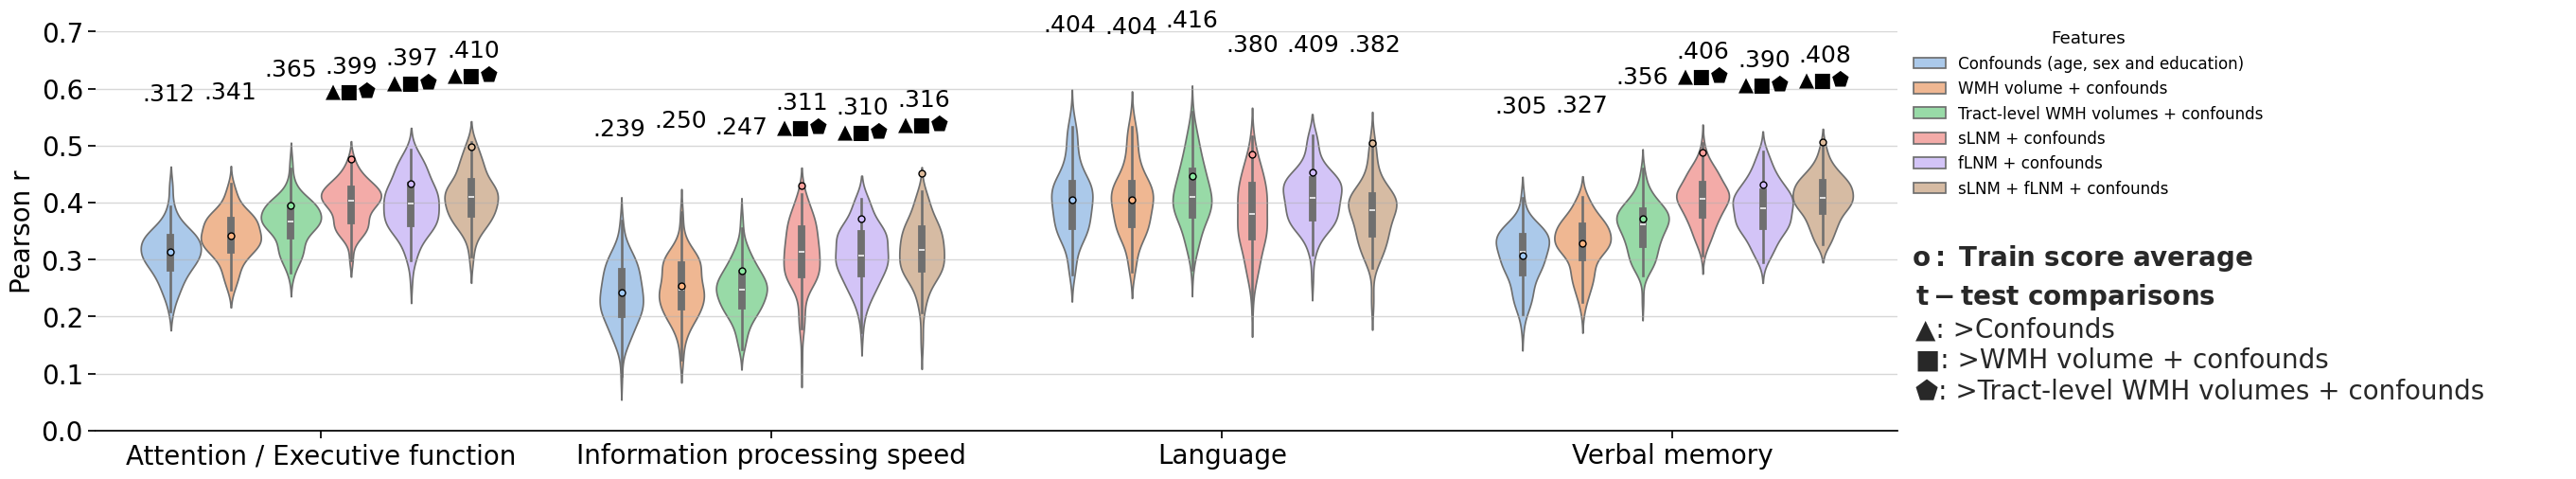

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

fontsize1=20
fontsize2=18

sns.set_context("notebook", font_scale=1.1)


# Create the catplot
g = sns.catplot(
    data=test_scores_plotting_df, kind="violin",
    x="variable", y="value", hue="index",
    palette="pastel", height=6, aspect=20,

)

train_scores_plotting_df_grouped_means = train_scores_plotting_df.groupby(["index","variable"]).mean()

s = sns.stripplot(x="variable", y="value", hue="index", data=train_scores_plotting_df_grouped_means,
                  dodge=True, ax=g.ax, palette="pastel", legend=False, edgecolor="black", linewidth=1)
plt.grid(visible=True, axis="y", alpha=0.5)

# Set figure size and other attributes
g.fig.set_size_inches(20, 5)
g.despine(left=True)
g.set_axis_labels("", "Pearson r", fontsize=fontsize1)
g.legend.set_title("")

g.set_xticklabels(fontsize=fontsize1)
g.set_yticklabels(fontsize=fontsize1)
sns.move_legend(g, "upper left", bbox_to_anchor=(.96, 1), title='Features')

# Get the number of levels for both hue and x-axis
n_hue_levels = len(test_scores_plotting_df['index'].unique())
n_x_levels = len(test_scores_plotting_df['variable'].unique())

# Get unique variables and indexes
unique_vars = test_scores_plotting_df['variable'].unique()
unique_indexes = test_scores_plotting_df['index'].unique()

# Calculate and add the mean values as text for each violin
for i, var in enumerate(unique_vars):
    for j, idx in enumerate(unique_indexes):
        # Filter the data for each group
        group_data = test_scores_plotting_df[(test_scores_plotting_df['variable'] == var) & 
                                             (test_scores_plotting_df['index'] == idx)]
        # Calculate mean for each group
        mean_val = group_data['value'].mean()
        max_val = group_data['value'].max()

        greater_confounds = True if pval_comparison_confounds_df.loc[idx,var] < 0.05 else False
        greater_WMHvol = True if pval_comparison_WMHvol_df.loc[idx,var] < 0.05 else False
        greater_roiWMHvol = True if pval_comparison_roiWMHvol_df.loc[idx,var] < 0.05 else False

        # Calculate the position of the mean value
        hue_offset = (j - (n_hue_levels - 1) / 2) * 0.135 
        position = i + hue_offset

        if "sLNM" in idx or "fLNM" in idx:
            if greater_confounds + greater_WMHvol + greater_roiWMHvol == 3:
                signif="▲■⬟"
            elif greater_confounds + greater_WMHvol == 2:
                signif="▲■"
            elif greater_confounds == True:
                signif="▲"
            else: signif=""
        else: signif=""

        # Place the text above the violin plot
        g.ax.text(position, max_val + 0.14, f'{mean_val:.3f}'.replace("0.","."), ha="center", va="bottom", fontsize=fontsize2)
        g.ax.text(position, max_val + 0.1, f'\n{signif}', ha="center", va="bottom", fontsize=fontsize2 -3)

plt.annotate("$\mathbf{t-test\ comparisons}$\n▲: >Confounds\n■: >WMH volume + confounds\n⬟: >Tract-level WMH volumes + confounds", 
             xy=(1.012,0.17), xycoords="figure fraction", color="#282828", fontsize=fontsize1)
plt.annotate("$\mathbf{o:\ Train\ score\ average}$", xy=(1.01,0.45), xycoords="figure fraction", color="#282828", fontsize=fontsize1)
plt.savefig(output_dir/'prediction_results_test_scores.png', dpi=300, bbox_inches='tight')

plt.show()


In [32]:
result_df

,attention,ips,language,verbal_memory
ridge_confounds,0.311770,0.239271,0.403976,0.305239
sLNM-plus-confounds_multimodel,0.398869,0.310813,0.379990,0.405759
fLNM-plus-confounds_multimodel,0.396630,0.311805,0.405592,0.394746
roiWMH-plus-confounds_multimodel,0.365040,0.246735,0.415976,0.355892
WMHvolume-plus-confounds_multimodel,0.340860,0.250344,0.404341,0.326670
all-no-wmh-plus-confounds_multimodel,0.407889,0.314363,0.380304,0.412549


# PALM preparations

In [22]:
from scipy.stats import zscore

palm_dir = project_dir/"output/roi_palm"

pd.DataFrame(schaefer_labels + tian_labels + hcp1065_labels).to_csv(palm_dir/"rois.txt", index=False, header=False)

for cognitive_domain in clinical_variables:
    for LNM_type in ["fLNM", "sLNM"]:
        Path(palm_dir/f"{LNM_type}_{cognitive_domain}").mkdir(exist_ok=True, parents=True)
        
        if LNM_type == "fLNM":
            palm_df = prediction_df[[cognitive_domain] + base_variables + schaefer_labels_fLNM_pos_mean + tian_labels_fLNM_pos_mean + hcp1065_labels_fLNM_pos_mean]
            palm_df = palm_df[[cognitive_domain] + base_variables + schaefer_labels_fLNM_pos_mean + tian_labels_fLNM_pos_mean + hcp1065_labels_fLNM_pos_mean]
        elif LNM_type == "sLNM":
            palm_df = prediction_df[[cognitive_domain] + base_variables + schaefer_labels_sLNM_pos_mean + tian_labels_sLNM_pos_mean + hcp1065_labels_sLNM_pos_mean]
            palm_df = palm_df[[cognitive_domain] + base_variables + schaefer_labels_sLNM_pos_mean + tian_labels_sLNM_pos_mean + hcp1065_labels_sLNM_pos_mean]

        palm_df.dropna(inplace=True)
        palm_df = palm_df.apply(zscore)

        palm_df[[cognitive_domain] + base_variables].to_csv(palm_dir/f"{LNM_type}_{cognitive_domain}/design.csv", index=False, header=False)
        palm_df.drop([cognitive_domain] + base_variables, axis=1).to_csv(palm_dir/f"{LNM_type}_{cognitive_domain}/input.csv", index=False, header=False)
        pd.DataFrame([1,0,0,0]).T.to_csv(palm_dir/f"{LNM_type}_{cognitive_domain}/contrast.csv", index=False, header=False)


# fLNM - sLNM Correlations

In [19]:
correlation_df_fLNM = prediction_df[schaefer_labels_fLNM_pos_mean + tian_labels_fLNM_pos_mean + hcp1065_labels_fLNM_pos_mean]
rois = [roi.split("GSP1000_")[1].split("_pos")[0] for roi in correlation_df_fLNM.columns.to_list()]
correlation_df_fLNM.columns = rois

correlation_df_sLNM = prediction_df[schaefer_labels_sLNM_pos_mean + tian_labels_sLNM_pos_mean + hcp1065_labels_sLNM_pos_mean]
rois = [roi.split("HCP32_")[1].split("_pos")[0] for roi in correlation_df_sLNM.columns.to_list()]
correlation_df_sLNM.columns = rois


In [20]:
from scipy.stats import pearsonr

correlation_dict = {}
for sub in correlation_df_fLNM.index:
    try: r, pval = pearsonr(correlation_df_fLNM.loc[sub], correlation_df_sLNM.loc[sub])
    except: r, pval = np.nan, np.nan
    correlation_dict[sub] = (r,pval)

correlation_df = pd.DataFrame(correlation_dict).T
correlation_df.columns = ["r","pval"]

correlation_df = correlation_df.join(prediction_df[clinical_variables + ["Diagnosis"] + base_variables])

In [ ]:
from scipy.stats import spearmanr
for var in clinical_variables:
    print(spearmanr(correlation_df[var], correlation_df["r"], nan_policy="omit"))

In [22]:
correlation_df["pval_bonf"] = correlation_df["pval"] * correlation_df.shape[0]

correlation_df["r_signif"] = correlation_df["r"]
correlation_df.loc[correlation_df["pval_bonf"] >= 0.05, "r_signif"] = None

correlation_df["r_non_signif"] = correlation_df["r"]
correlation_df.loc[correlation_df["pval_bonf"] < 0.05, "r_non_signif"] = None

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the plot
plt.figure(figsize=(8, 6))

sns.stripplot(data=correlation_df, y="r_signif", hue="r", legend=False, alpha=1, jitter=0.3, edgecolor="white", linewidth=0.5)
sns.stripplot(data=correlation_df, y="r_non_signif", hue="r", legend=False, alpha=0.3, jitter=0.3, edgecolor="white", linewidth=0.5)

sns.despine(left=True, bottom=True)
plt.grid(True, axis="y")
plt.xlabel("")
plt.ylabel("Pearson r", fontsize=12)
plt.title("Subject-level correlation of fLNM and sLNM scores across ROIs", fontsize=14)
plt.savefig(f"{output_dir}/subject_level_correlation_fLNM_sLNM.png", dpi=300)

In [ ]:
from scipy.stats import pearsonr

correlation_roilevel_dict = {}
for roi in correlation_df_fLNM.columns:
    subject_list = [sub for sub in correlation_df_fLNM.index if sub in correlation_df_sLNM.index]
    mask = correlation_df_fLNM.loc[subject_list,roi].notnull() & correlation_df_sLNM.loc[subject_list,roi].notnull()
    r, pval = pearsonr(correlation_df_fLNM.loc[subject_list,roi][mask], correlation_df_sLNM.loc[subject_list,roi][mask])
    correlation_roilevel_dict[roi] = (r,pval)

correlation_roilevel_df = pd.DataFrame(correlation_roilevel_dict).T
correlation_roilevel_df.columns = ["r","pval"]

In [27]:
correlation_roilevel_df["pval_bonf"] = correlation_roilevel_df["pval"] * correlation_roilevel_df.shape[0]

correlation_roilevel_df["r_signif"] = correlation_roilevel_df["r"]
correlation_roilevel_df.loc[correlation_roilevel_df["pval_bonf"] >= 0.05, "r_signif"] = None

correlation_roilevel_df["r_non_signif"] = correlation_roilevel_df["r"]
correlation_roilevel_df.loc[correlation_roilevel_df["pval_bonf"] < 0.05, "r_non_signif"] = None

### Cortex

In [ ]:
cmap="flare"
plot = plot_schaefer_on_fslr(
    data_schaefer400=correlation_roilevel_df["r_signif"].values.flatten()[:400],
    label_text="Pearson r", layout="grid", size=(400,200), zoom=1.8,
    cmap=cmap)
plt.title("ROI-level correlation of fLNM and sLNM scores across subjects", fontsize=10)
plot.savefig(output_dir/f"LNM_correlation_surfplot.png", dpi=300)

### Subcortex

In [29]:
# Load cortico-cortical functional connectivity data

sctx_labels = ['Laccumb', 'Lamyg', 'Lcaud', 'Lhippo', 'Lpal', 'Lput', 'Lthal',
       'Raccumb', 'Ramyg', 'Rcaud', 'Rhippo', 'Rpal', 'Rput', 'Rthal']

mapping_subcortical = {
 'Laccumb':'NAc-lh', 
 'Lamyg':'AMY-lh',
 'Lcaud':'CAU-lh',
 'Lhippo':'HIP-lh',
 'Lpal':'GP-lh',
 'Lput':'PUT-lh',
 'Lthal':'THA-lh',
 'Raccumb':'NAc-rh',
 'Ramyg':'AMY-rh',
 'Rcaud':'CAU-rh',
 'Rhippo':'HIP-rh',
 'Rpal':'GP-rh',
 'Rput':'PUT-rh',
 'Rthal':'THA-rh'}
from enigmatoolbox.plotting import plot_subcortical

# Project the results on the surface brain

v = correlation_roilevel_df["r_signif"][400:416]

values = []
for label in sctx_labels:
    label_mapped = mapping_subcortical[label]
    if "THA-lh" in label_mapped:
        values = np.append(values, v["aTHA-lh"] + v["pTHA-lh"] / 2)
    elif "THA-rh" in label_mapped:
        values = np.append(values, v["aTHA-rh"] + v["pTHA-rh"] / 2)
    elif label_mapped: values = np.append(values, v[label_mapped])
    else: values = np.append(values, None)

values = np.nan_to_num(values, copy=True, nan=0)
values = np.array(values)

plot = plot_subcortical(array_name=values, size=(800, 200),

                cmap='flare', color_bar=False, color_range=(-0.200, 0.200),
                
                embed_nb=True, interactive=False, ventricles = False, transparent_bg=False,
                
                screenshot=True, filename=f"{output_dir}/LNM_correlation_subcortical.png", scale=4)

# WM Tracts

In [30]:
labels_tracts = correlation_roilevel_df.iloc[416:].index

commissural = [
    "Corpus_Callosum_Body",
    "Corpus_Callosum_Forceps_Major",
    "Corpus_Callosum_Forceps_Minor",
    "Corpus_Callosum_Tapetum",
]

association_l = [
    "Arcuate_Fasciculus_L",
    "Cingulum_Frontal_Parahippocampal_L",
    "Cingulum_Frontal_Parietal_L",
    "Cingulum_Parahippocampal_L",
    "Cingulum_Parahippocampal_Parietal_L",
    "Cingulum_Rarolfactory_L",
    "Frontal_Aslant_Tract_L",
    "Inferior_Fronto_Occipital_Fasciculus_L",
    "Inferior_Longitudinal_Fasciculus_L",
    "Middle_Longitudinal_Fasciculus_L",
    "Parietal_Aslant_Tract_L",
    "Superior_Longitudinal_Fasciculus1_L",
    "Superior_Longitudinal_Fasciculus2_L",
    "Superior_Longitudinal_Fasciculus3_L",
    "Uncinate_Fasciculus_L",
]

association_r = [
    "Arcuate_Fasciculus_R",
    "Cingulum_Frontal_Parahippocampal_R",
    "Cingulum_Frontal_Parietal_R",
    "Cingulum_Parahippocampal_R",
    "Cingulum_Parahippocampal_Parietal_R",
    "Cingulum_Rarolfactory_R",
    "Frontal_Aslant_Tract_R",
    "Inferior_Fronto_Occipital_Fasciculus_R",
    "Inferior_Longitudinal_Fasciculus_R",
    "Middle_Longitudinal_Fasciculus_R",
    "Parietal_Aslant_Tract_R",
    "Superior_Longitudinal_Fasciculus1_R",
    "Superior_Longitudinal_Fasciculus2_R",
    "Superior_Longitudinal_Fasciculus3_R",
    "Uncinate_Fasciculus_R",
]

projection_l = [
    "Corticobulbar_Tract_L",
    "Corticopontine_Tract_Frontal_L",
    "Corticopontine_Tract_Occipital_L",
    "Corticopontine_Tract_Parietal_L",
    "Corticostriatal_Tract_Anterior_L",
    "Corticostriatal_Tract_Posterior_L",
    "Corticostriatal_Tract_Superior_L",
    "Corticospinal_Tract_L",
    "Fornix_L",
    "Optic_Radiation_L",
    "Thalamic_Radiation_Anterior_L",
    "Thalamic_Radiation_Posterior_L",
    "Thalamic_Radiation_Superior_L",
    "Vertical_Occipital_Fasciculus_L",
]

projection_r = [
    "Corticobulbar_Tract_R",
    "Corticopontine_Tract_Frontal_R",
    "Corticopontine_Tract_Occipital_R",
    "Corticopontine_Tract_Parietal_R",
    "Corticostriatal_Tract_Anterior_R",
    "Corticostriatal_Tract_Posterior_R",
    "Corticostriatal_Tract_Superior_R",
    "Corticospinal_Tract_R",
    "Fornix_R",
    "Optic_Radiation_R",
    "Thalamic_Radiation_Anterior_R",
    "Thalamic_Radiation_Posterior_R",
    "Thalamic_Radiation_Superior_R",
    "Vertical_Occipital_Fasciculus_R",
]

toi_group_dict = {
    "Commissural": commissural,
    "Association left": association_l,
    "Association right": association_r,
    "Projection left": projection_l,
    "Projection right": projection_r,
}

tract_abbreviation_dict = {
    "Corpus_Callosum_Body": "CC body",
    "Corpus_Callosum_Forceps_Major": "CC forceps major",
    "Corpus_Callosum_Forceps_Minor": "CC forceps minor",
    "Corpus_Callosum_Tapetum": "CC tapetum",

    "Arcuate_Fasciculus_L" : "AF L",
    "Cingulum_Frontal_Parahippocampal_L": "C frontoparahipp. L",
    "Cingulum_Frontal_Parietal_L" : "C frontoparietal L",
    "Cingulum_Parahippocampal_L": "C parahippocampal L",
    "Cingulum_Parahippocampal_Parietal_L": "C parietoparahipp. L",
    "Cingulum_Rarolfactory_L": "C parolfactory L",
    "Inferior_Fronto_Occipital_Fasciculus_L": "IFOF L",
    "Inferior_Longitudinal_Fasciculus_L": "ILF L",
    "Middle_Longitudinal_Fasciculus_L": "MdLF L",
    "Frontal_Aslant_Tract_L": "FAT L",
    "Parietal_Aslant_Tract_L": "PAT L",
    "Superior_Longitudinal_Fasciculus1_L": "SLF 1 L",
    "Superior_Longitudinal_Fasciculus2_L": "SLF 2 L",
    "Superior_Longitudinal_Fasciculus3_L": "SLF 3 L",
    "Uncinate_Fasciculus_L": "UF L",

    "Arcuate_Fasciculus_R" : "AF R",
    "Cingulum_Frontal_Parahippocampal_R": "C frontoparahipp. R",
    "Cingulum_Frontal_Parietal_R" : "C frontoparietal R",
    "Cingulum_Parahippocampal_R": "C parahippocampal R",
    "Cingulum_Parahippocampal_Parietal_R": "C parietoparahipp. R",
    "Cingulum_Rarolfactory_R": "C parolfactory R",
    "Inferior_Fronto_Occipital_Fasciculus_R": "IFOF R",
    "Inferior_Longitudinal_Fasciculus_R": "ILF R",
    "Middle_Longitudinal_Fasciculus_R": "MdLF R",
    "Frontal_Aslant_Tract_R": "FAT R",
    "Parietal_Aslant_Tract_R": "PAT R",
    "Superior_Longitudinal_Fasciculus1_R": "SLF 1 R",
    "Superior_Longitudinal_Fasciculus2_R": "SLF 2 R",
    "Superior_Longitudinal_Fasciculus3_R": "SLF 3 R",
    "Uncinate_Fasciculus_R": "UF R",

    "Corticobulbar_Tract_L": "CBT L",
    "Corticopontine_Tract_Frontal_L": "CPT frontal L",
    "Corticopontine_Tract_Occipital_L": "CPT occipital L",
    "Corticopontine_Tract_Parietal_L": "CPT parietal L",
    "Corticospinal_Tract_L": "CST L",
    "Corticostriatal_Tract_Anterior_L": "CS anterior L",
    "Corticostriatal_Tract_Posterior_L": "CS posterior L",
    "Corticostriatal_Tract_Superior_L": "CS superior L",
    "Fornix_L": "Fornix L",
    "Optic_Radiation_L": "OR L",
    "Thalamic_Radiation_Anterior_L": "Thalamic radiation ant. L",
    "Thalamic_Radiation_Posterior_L": "Thalamic radiation post. L",
    "Thalamic_Radiation_Superior_L": "Thalamic radiation sup. L",
    "Vertical_Occipital_Fasciculus_L": "VOF L",

    "Corticobulbar_Tract_R": "CBT R",
    "Corticopontine_Tract_Frontal_R": "CPT frontal R",
    "Corticopontine_Tract_Occipital_R": "CPT occipital R",
    "Corticopontine_Tract_Parietal_R": "CPT parietal R",
    "Corticospinal_Tract_R": "CST R",
    "Corticostriatal_Tract_Anterior_R": "CS anterior R",
    "Corticostriatal_Tract_Posterior_R": "CS posterior R",
    "Corticostriatal_Tract_Superior_R": "CS superior R",
    "Fornix_R": "Fornix R",
    "Optic_Radiation_R": "OR R",
    "Thalamic_Radiation_Anterior_R": "Thalamic radiation ant. R",
    "Thalamic_Radiation_Posterior_R": "Thalamic radiation post. R",
    "Thalamic_Radiation_Superior_R": "Thalamic radiation sup. R",
    "Vertical_Occipital_Fasciculus_R": "VOF R",
}

In [32]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the 'flare' colormap from Seaborn
flare_cmap = sns.color_palette("flare", as_cmap=True)

# Number of colors to sample
n_colors = 10

# Sample colors from the 'flare' colormap
flare_colors = [flare_cmap(i / (n_colors - 1)) for i in range(n_colors)]

# Convert colors to hex format for ease of use in Plotly
flare_hex_colors = [mcolors.rgb2hex(c) for c in flare_colors]

import plotly.graph_objs as go

# Create a color scale for Plotly
plotly_flare_scale = [(i / (n_colors - 1), color) for i, color in enumerate(flare_hex_colors)]


In [33]:
import plotly.graph_objects as go

effects = correlation_roilevel_df.iloc[416:]["r"]
effects_signif = correlation_roilevel_df.iloc[416:]["r_signif"]

roistats_df = pd.DataFrame({"effects": effects.values.flatten(), "effects_signif": effects_signif.values.flatten()}, index=labels_tracts)

fig_list = []

for k, v in toi_group_dict.items():
    v = [f"{roi}" for roi in v]

    roistats_df_group = roistats_df.loc[sorted(v)].reset_index()
    roistats_df_group["index"] = roistats_df_group["index"].str.replace(".nii.gz","")
    roistats_df_group["index"] = roistats_df_group["index"].map(tract_abbreviation_dict)

    import plotly.express as px
    import plotly.graph_objs as go

    # Determine color map based on the range of 'effects'
    if roistats_df_group["effects"].max() < 0:
        cmap = "Reds_r"
    elif roistats_df_group["effects"].min() > 0:
        cmap = "Blues_r"
    else:
        cmap = "RdBu"

    if "Commissural" in k: showlegend=True
    else: showlegend=False

    # Create a new figure
    fig = go.Figure()

    # Add the 'effects' scatter plot
    fig.add_trace(go.Scatterpolar(
        r=roistats_df_group['effects'],
        theta=roistats_df_group['index'],
        mode='markers',
        name='n.s.',
        marker=dict(color=roistats_df_group['effects'], opacity=0.2, coloraxis="coloraxis", line=dict(width=0.5, color="Black")),
        
    ))

    # Add the 'effects_signif' scatter plot
    fig.add_trace(go.Scatterpolar(
        r=roistats_df_group['effects_signif'],
        theta=roistats_df_group['index'],
        mode='markers',
        name='p<0.05',
        marker=dict(color=roistats_df_group['effects'], coloraxis="coloraxis", line=dict(width=0.5, color="Darkgray")),
        opacity=1
    ))

    # Update figure layout
    fig.update_layout(
        title=f"{k}",
        title_x=0.5,
        width=470,
        height=400,
        coloraxis=dict(colorscale=plotly_flare_scale),#, cmin=-0.2, cmax=0.2),
        polar=dict(radialaxis=dict(nticks=5)),#, radialaxis_range=[0.225, -0.225]),
        legend_title_text=r'',
        showlegend=showlegend,
        coloraxis_showscale=False
    )

    fig_list.append(fig)
    fig.show()
    fig.write_image(output_dir/f"LNM_correlation_wmtracts_{k}.png", scale=4)


# ROIwise average

In [220]:
from scipy.stats import zscore
def zscore_(x):
    return (x - x.mean()) / x.std()
average_df_fLNM = fLNM_df[schaefer_labels_fLNM_pos_mean + tian_labels_fLNM_pos_mean + hcp1065_labels_fLNM_pos_mean]
average_df_sLNM = sLNM_df[schaefer_labels_sLNM_pos_mean + tian_labels_sLNM_pos_mean + hcp1065_labels_sLNM_pos_mean]

def log_(x):
    return np.log(x + 1)

# average_df_fLNM = average_df_fLNM.apply(zscore_, axis=1).mean(axis=0)
# average_df_sLNM = average_df_sLNM.apply(zscore_, axis=1).mean(axis=0)
average_df_fLNM = average_df_fLNM.apply(log_, axis=0).mean(axis=0)
average_df_sLNM = average_df_sLNM.apply(log_, axis=0).mean(axis=0)

mean_fLNM = average_df_fLNM.values.flatten().mean()
std_fLNM = average_df_fLNM.values.flatten().std()
max_fLNM = average_df_fLNM.values.flatten().max()

mean_sLNM = average_df_sLNM.values.flatten().mean()
std_sLNM = average_df_sLNM.values.flatten().std()
max_sLNM = average_df_sLNM.values.flatten().max()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


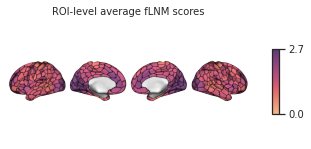

In [229]:
cmap="flare"
plot = plot_schaefer_on_fslr(
    data_schaefer400=average_df_fLNM.values.flatten()[:400], color_range=(0,max_fLNM),
    label_text="", layout="row", size=(400,200), zoom=1.2, 
    cmap=cmap)
plt.title("ROI-level average fLNM scores", fontsize=10)
plot.savefig(output_dir/f"average_surfplot_fLNM.png", dpi=300)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


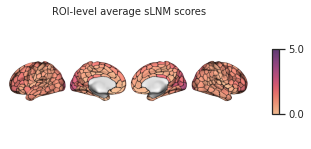

In [226]:
plot = plot_schaefer_on_fslr(
    data_schaefer400=average_df_sLNM.values.flatten()[:400],color_range=(0,max_sLNM),
    label_text="", layout="row", size=(400,200), zoom=1.2,
    cmap=cmap)
plt.title("ROI-level average sLNM scores", fontsize=10)
plot.savefig(output_dir/f"average_surfplot_sLNM.png", dpi=300)

In [180]:
def style(label):

    label = "fLNM_GSP1000_" + label + "_pos_mean"

    return label

sctx_labels = ['Laccumb', 'Lamyg', 'Lcaud', 'Lhippo', 'Lpal', 'Lput', 'Lthal',
       'Raccumb', 'Ramyg', 'Rcaud', 'Rhippo', 'Rpal', 'Rput', 'Rthal']

mapping_subcortical = {
 'Laccumb':'NAc-lh', 
 'Lamyg':'AMY-lh',
 'Lcaud':'CAU-lh',
 'Lhippo':'HIP-lh',
 'Lpal':'GP-lh',
 'Lput':'PUT-lh',
 'Lthal':'THA-lh',
 'Raccumb':'NAc-rh',
 'Ramyg':'AMY-rh',
 'Rcaud':'CAU-rh',
 'Rhippo':'HIP-rh',
 'Rpal':'GP-rh',
 'Rput':'PUT-rh',
 'Rthal':'THA-rh'}

from enigmatoolbox.plotting import plot_subcortical

# Project the results on the surface brain

v = average_df_fLNM

values = []
for label in sctx_labels:
    label_mapped = mapping_subcortical[label]
    if "THA-lh" in label_mapped:
        values = np.append(values, v[style("aTHA-lh")] + v[style("pTHA-lh")] / 2)
    elif "THA-rh" in label_mapped:
        values = np.append(values, v[style("aTHA-rh")] + v[style("pTHA-rh")] / 2)
    elif label_mapped: values = np.append(values, v[style(label_mapped)])
    else: values = np.append(values, None)

values = np.nan_to_num(values, copy=True, nan=0)
values = np.array(values)

plot = plot_subcortical(array_name=values, size=(800, 200),

                cmap='flare', color_bar=False, color_range=(0, max_fLNM),
                
                embed_nb=True, interactive=False, ventricles = False, transparent_bg=False,
                
                screenshot=True, filename=f"{output_dir}/average_fLNM_subcortical.png", scale=4)

In [181]:
def style(label):

    label = "sLNM_HCP32_" + label + "_pos_mean"

    return label

v = average_df_sLNM

values = []
for label in sctx_labels:
    label_mapped = mapping_subcortical[label]
    if "THA-lh" in label_mapped:
        values = np.append(values, v[style("aTHA-lh")] + v[style("pTHA-lh")] / 2)
    elif "THA-rh" in label_mapped:
        values = np.append(values, v[style("aTHA-rh")] + v[style("pTHA-rh")] / 2)
    elif label_mapped: values = np.append(values, v[style(label_mapped)])
    else: values = np.append(values, None)

values = np.nan_to_num(values, copy=True, nan=0)
values = np.array(values)

plot = plot_subcortical(array_name=values, size=(800, 200),

                cmap='flare', color_bar=False, color_range=(0, max_sLNM),
                
                embed_nb=True, interactive=False, ventricles = False, transparent_bg=False,
                
                screenshot=True, filename=f"{output_dir}/average_sLNM_subcortical.png", scale=4)

In [134]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the 'flare' colormap from Seaborn
flare_cmap = sns.color_palette("flare", as_cmap=True)

# Number of colors to sample
n_colors = 10

# Sample colors from the 'flare' colormap
flare_colors = [flare_cmap(i / (n_colors - 1)) for i in range(n_colors)]

# Convert colors to hex format for ease of use in Plotly
flare_hex_colors = [mcolors.rgb2hex(c) for c in flare_colors]

import plotly.graph_objs as go

# Create a color scale for Plotly
plotly_flare_scale = [(i / (n_colors - 1), color) for i, color in enumerate(flare_hex_colors)]


In [182]:
import plotly.graph_objects as go

effects = average_df_fLNM.values.flatten()[416:]

roistats_df = pd.DataFrame({"effects": effects}, index=labels_tracts)

fig_list = []

for k, v in toi_group_dict.items():
    v = [f"{roi}" for roi in v]

    roistats_df_group = roistats_df.loc[sorted(v)].reset_index()
    roistats_df_group["index"] = roistats_df_group["index"].str.replace(".nii.gz","")
    roistats_df_group["index"] = roistats_df_group["index"].map(tract_abbreviation_dict)

    import plotly.express as px
    import plotly.graph_objs as go

    # Create a new figure
    fig = go.Figure()

    # Add the 'effects' scatter plot
    fig.add_trace(go.Scatterpolar(
        r=roistats_df_group['effects'],
        theta=roistats_df_group['index'],
        mode='markers',
        name='',
        marker=dict(color=roistats_df_group['effects'], opacity=1, coloraxis="coloraxis", line=dict(width=0.5, color="Black")),
        
    ))

    # Update figure layout
    fig.update_layout(
        title=f"{k}",
        title_x=0.5,
        width=470,
        height=400,
        coloraxis=dict(colorscale=plotly_flare_scale),#, cmin=-0.2, cmax=0.2),
        polar=dict(radialaxis=dict(nticks=5)),#, radialaxis_range=[0.225, -0.225]),
        legend_title_text=r'',
        showlegend=False,
        coloraxis_showscale=False
    )

    fig_list.append(fig)
    fig.show()
    fig.write_image(output_dir/f"average_fLNM_wmtracts_{k}.png", scale=4)


In [230]:
import plotly.graph_objects as go

effects = average_df_sLNM.values.flatten()[416:]

roistats_df = pd.DataFrame({"effects": effects}, index=labels_tracts)

fig_list = []

for k, v in toi_group_dict.items():
    v = [f"{roi}" for roi in v]

    roistats_df_group = roistats_df.loc[sorted(v)].reset_index()
    roistats_df_group["index"] = roistats_df_group["index"].str.replace(".nii.gz","")
    roistats_df_group["index"] = roistats_df_group["index"].map(tract_abbreviation_dict)

    import plotly.express as px
    import plotly.graph_objs as go

    if "Commissural" in k: showlegend=True
    else: showlegend=False

    # Create a new figure
    fig = go.Figure()

    # Add the 'effects' scatter plot
    fig.add_trace(go.Scatterpolar(
        r=roistats_df_group['effects'],
        theta=roistats_df_group['index'],
        mode='markers',
        marker=dict(color=roistats_df_group['effects'], opacity=1, coloraxis="coloraxis", line=dict(width=0.5, color="Black")),
        
    ))

    # Update figure layout
    fig.update_layout(
        title=f"{k}",
        title_x=0.5,
        width=470,
        height=400,
        coloraxis=dict(colorscale=plotly_flare_scale),#, cmin=-0.2, cmax=0.2),
        polar=dict(radialaxis=dict(nticks=5)),#, radialaxis_range=[0.225, -0.225]),
        legend_title_text=r'',
        showlegend=False,
        coloraxis_showscale=False
    )

    fig_list.append(fig)
    fig.show()
    fig.write_image(output_dir/f"average_sLNM_wmtracts_{k}.png", scale=4)
